In [71]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout,Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

In [73]:
epochs = 100
lr = 1e-3
batch_size = 64
img_dims = (96,96,3)

In [75]:
data = []
labels = []

In [19]:
image_files = [f for f in glob.glob(r'gender_dataset_face' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

In [21]:
for img in image_files:

    image = cv2.imread(img)
    
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2] # C:\Files\gender_dataset_face\woman\face_1162.jpg
    if label == "woman":
        label = 1
    else:
        label = 0
        
    labels.append([label]) # [[1], [0], [0], ...]

# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)

In [23]:
trainY = to_categorical(trainY,num_classes=2)
testY = to_categorical(testY,num_classes=2)

In [25]:
aug = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"  
)

In [39]:
def build(width,height,depth,classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = -1

    
    model.add(Conv2D(32,(3,3), padding="same", input_shape = inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis = chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Dense(classes))
    model.add(Activation("sigmoid"))
    return model
    

In [41]:
model = build(width=img_dims[0],height=img_dims[1],depth=img_dims[2], classes=2)

C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
opt = Adam(learning_rate=lr, decay=lr/epochs)
model.compile(loss = "binary_crossentropy", optimizer=opt, metrics=["accuracy"])

C:\Users\user\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [49]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size=batch_size),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // batch_size,
    epochs=epochs,
    verbose=1
)

Epoch 1/100


C:\Users\user\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6661 - loss: 0.9307 - val_accuracy: 0.5195 - val_loss: 0.7414
Epoch 2/100
 1/28 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8125 - loss: 0.5346

C:\Users\user\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.8125 - loss: 0.5346 - val_accuracy: 0.5238 - val_loss: 0.7543
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8122 - loss: 0.4901 - val_accuracy: 0.5152 - val_loss: 1.1448
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9062 - loss: 0.3292 - val_accuracy: 0.5152 - val_loss: 1.1620
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8458 - loss: 0.4187 - val_accuracy: 0.5152 - val_loss: 1.3115
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.7736 - loss: 0.5661 - val_accuracy: 0.5195 - val_loss: 1.2885
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8678 - loss: 0.3454 - val_accuracy: 0.5152 - val_loss: 1.5169
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8125 - loss: 0.4510 - val_accuracy: 0.5152 - val_loss: 1.7146
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8592 - loss: 0.3204 - val_accuracy: 0.5152 - val_loss:

In [55]:
model.save('gender_detection_model_byTalha.h5')

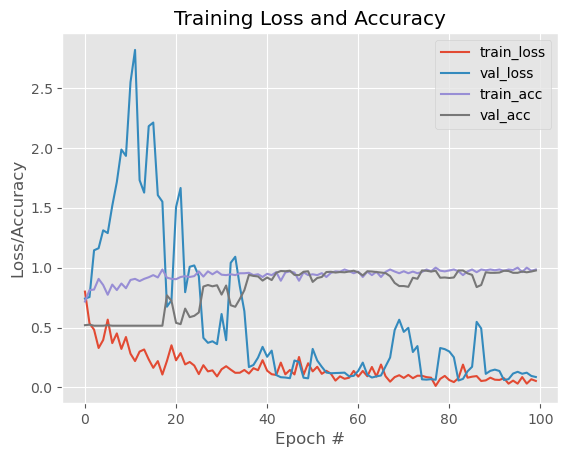

In [61]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.show()


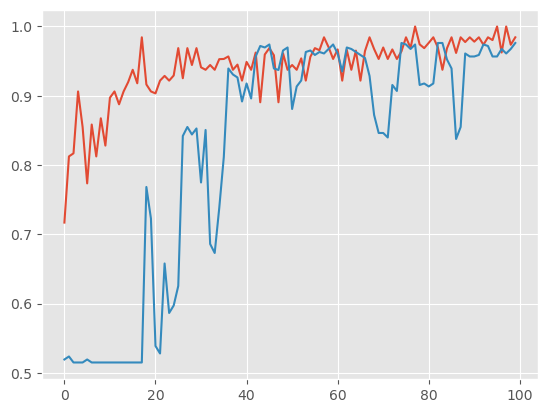

In [59]:
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")


In [12]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os
import cvlib as cv

In [14]:
model = load_model('gender_detection_model_byTalha.h5')

In [22]:
webcam = cv2.VideoCapture(0)
classes = ['man','women']

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import cvlib as cv

# Load pre-trained model
model = load_model('gender_detection_model_byTalha.h5')

# Start video capture
webcam = cv2.VideoCapture(0)

# Correct class labels (man and woman)
classes = ['man', 'woman']  # Check the exact labels the model was trained on

while webcam.isOpened():
    # Read frame from webcam
    status, frame = webcam.read()

    # Apply face detection
    face, confidence = cv.detect_face(frame)

    # Loop through detected faces
    for idx, f in enumerate(face):
        # Get corner points of face rectangle
        (startX, startY) = f[0], f[1]
        (endX, endY) = f[2], f[3]

        # Draw placeholder rectangle over face
        color = (0, 255, 0)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

        # Crop the detected face region
        face_crop = np.copy(frame[startY:endY, startX:endX])

        if face_crop.shape[0] < 10 or face_crop.shape[1] < 10:
            continue

        # Preprocess the cropped face for model prediction
        face_crop = cv2.resize(face_crop, (96, 96))
        face_crop = face_crop.astype("float") / 255.0
        face_crop = img_to_array(face_crop)
        face_crop = np.expand_dims(face_crop, axis=0)

        # Predict gender
        conf = model.predict(face_crop)[0]

        # Get label with max confidence
        idx = np.argmax(conf)
        label = classes[idx]

        # Debug: Print label to confirm correct classification
        print(f"Predicted label: {label}, Confidence: {conf[idx] * 100:.2f}%")

        # Set label and color based on gender
        if label == "man":
            label = "male"
            color = (255, 0, 0)  # Blue for male
        elif label == "woman":
            label = "female"
            color = (255, 105, 180)  # Pink for female

        # Format label with confidence
        label_text = "{}: {:.2f}%".format(label, conf[idx] * 100)

        # Position label text
        Y = startY - 10 if startY - 10 > 10 else startY + 10

        # Write label and confidence above face rectangle
        cv2.putText(frame, label_text, (startX, Y), cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, color, 2)

        # Draw rectangle with the gender-specific color
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

    # Display output
    cv2.imshow("Gender Detection", frame)

    # Press "Q" to stop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
webcam.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
Predicted label: man, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted label: man, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted label: man, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted label: man, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted label: man, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted label: man, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted label: man, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted label: man, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted label: man, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted label: man, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted label: man, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted label: man, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
P